<a href="https://colab.research.google.com/github/vishnucramesh/deepfake-detection/blob/master/DeepfakeDetector_VGG_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Step 1: Upload the API key file provided by kaggle to a location in google drive
Step 2: Set the config file as the environemnt variable
Step 5: Change working directory
Step 3: Get kaggle download link from kaggle 
"""

import os

!pip install kaggle


PATH = '/Users/vishnu/Work/uni/VISOPE/deepfake-image-detector/dataset'

# set kaggle config file directory
os.environ['KAGGLE_CONFIG_DIR'] = PATH

%cd $PATH

!kaggle datasets download -d xhlulu/140k-real-and-fake-faces --unzip

In [11]:
pip install tensorflow matplotlib pillow sklearn git+https://github.com/yaledhlab/vggface.git


  Cloning https://github.com/yaledhlab/vggface.git to /private/var/folders/vf/0mnhf6cj1_z55h9c333rzgrh0000gn/T/pip-req-build-4ibvrcvv
  Running command git clone --filter=blob:none --quiet https://github.com/yaledhlab/vggface.git /private/var/folders/vf/0mnhf6cj1_z55h9c333rzgrh0000gn/T/pip-req-build-4ibvrcvv
  Resolved https://github.com/yaledhlab/vggface.git to commit b76539b7588bca69b0030ad7e4f985f877dc7c0a
  Preparing metadata (setup.py) ... - done
Note: you may need to restart the kernel to use updated packages.


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Convolution2D, MaxPooling2D, \
                                    BatchNormalization, BatchNormalization, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
base_path = '/Users/vishnu/Work/uni/VISOPE/deepfake-image-detector/dataset/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


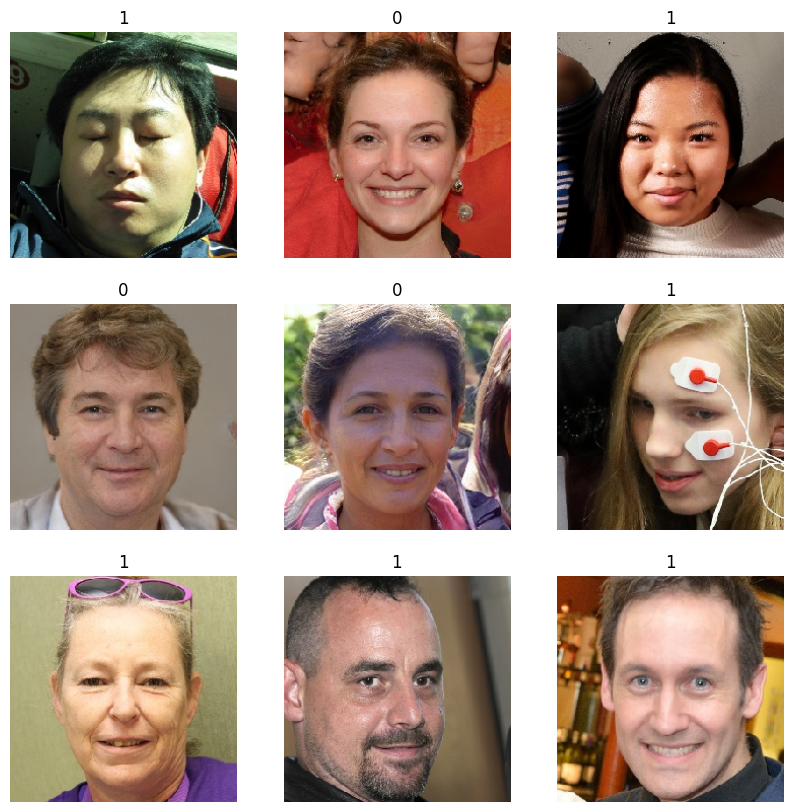

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_flow:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [50]:
input_shape = (224,224,3)
activation = 'relu'
padding = 'same'
droprate = 0.1
epsilon=0.001

vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape) 

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg19 is now flattened. 
prediction = Dense(1, activation='softmax')(x) # We have 2 classes

#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)

model.build(input_shape)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [43]:
# for layer in model.layers:
#   print(layer.name)
#   layer.trainable = False

input_11
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten_6
dense_7


In [44]:
# x = Flatten()(model.output) #Output obtained on vgg19 is now flattened. 
# prediction = Dense(2, activation='softmax')(x)

In [51]:
model.compile(loss='binary_crossentropy',optimizer=Adam(0.0001), metrics=['accuracy'])

In [57]:
steps_per_epoch = 10
validation_steps = 5

earlystop_callback = EarlyStopping(monitor='loss', patience=3)
checkpoint_callback = ModelCheckpoint(filepath=f"model.hdf5", 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

history = model.fit(
      valid_flow,
      epochs=10,
      steps_per_epoch = steps_per_epoch,
      validation_data = test_flow,
      validation_steps = validation_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.4828
Epoch 1: val_loss improved from inf to 0.58152, saving model to model.hdf5
10/10 [==============================] - 296s 32s/step - loss: 0.5736 - accuracy: 0.4828 - val_loss: 0.5815 - val_accuracy: 0.4894
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.58152 to 0.57514, saving model to model.hdf5
10/10 [==============================] - 305s 33s/step - loss: 0.5681 - accuracy: 0.5000 - val_loss: 0.5751 - val_accuracy: 0.4938
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.5078
Epoch 3: val_loss improved from 0.57514 to 0.56245, saving model to model.hdf5
10/10 [==============================] - 314s 34s/step - loss: 0.5364 - accuracy: 0.5078 - val_loss: 0.5625 - val_accuracy: 0.5044
Epoch 4/10
 9/10 [==========================>...] - ETA: 9s - loss: 0.5699 - accuracy: 0.508

KeyboardInterrupt: ignored

In [ ]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: ignored

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [ ]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [ ]:
from sklearn import metrics

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))

print("AP Score:", metrics.average_precision_score(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred > 0.5))
